In [ ]:
import numpy as np
import pandas as pd
import logging
import os
import argparse
import os

import numpy as np
import pandas as pd

from memory import garbage_collect

log = lambda msg: logging.info(msg)


# Load data

In [ ]:
input_dir = "C:\\dev\\play\\brainwave-data"


In [ ]:
import stitch_pipeline_results
from importlib import reload
reload(stitch_pipeline_results)

df_orig = stitch_pipeline_results.stitch_all_days_optimised(input_dir)
df = df_orig.copy()

In [56]:
import convert

small = "C:\\dev\\play\\brainwave-data\\2024-11-21-21-15-26\\raw.fif"
# small = "C:\\dev\\play\\brainwave-data\\2024-07-22-22-24-06\\raw.fif"
# large = "C:\\dev\\play\\brainwave-data\\2024-12-19-21-18-48\\raw.fif"
raw, input_file_without_ext, mne_filtered = convert.load_mne_file(log, small)
# raw_large, _, mne_filtered_large = convert.load_mne_file(log, large)


Opening raw data file C:\dev\play\brainwave-data\2024-11-21-21-15-26\raw.fif...
Isotrak not found
    Range : 0 ... 8391098 =      0.000 ... 33564.392 secs
Ready.
Reading 0 ... 8391098  =      0.000 ... 33564.392 secs...


In [58]:
epoch_index_small = 862
# epoch_index_large = 339

sf = 250.
epoch_length = 30
samples_per_epoch = int(epoch_length * sf)

# data_small = mne_filtered.get_data(units='uV', picks='F8-M1')[0]
data_small = mne_filtered.get_data(units='uV')[0]
# data_large = mne_filtered_large.get_data(units='uV')[0]

# data_small_raw = raw.get_data(units='uV', picks='F8-M1')[0]
data_small_raw = raw.get_data(units='uV')[0]
# data_large_raw = raw_large.get_data(units='uV')[0]

epoch_data_small = data_small[epoch_index_small * samples_per_epoch : (epoch_index_small + 1) * samples_per_epoch]
# epoch_data_large = data_large[epoch_index_large * samples_per_epoch : (epoch_index_large + 1) * samples_per_epoch]

epoch_data_small_raw = data_small_raw[epoch_index_small * samples_per_epoch : (epoch_index_small + 1) * samples_per_epoch]
# epoch_data_large_raw = data_large_raw[epoch_index_large * samples_per_epoch : (epoch_index_large + 1) * samples_per_epoch]

epoch_data = epoch_data_small_raw

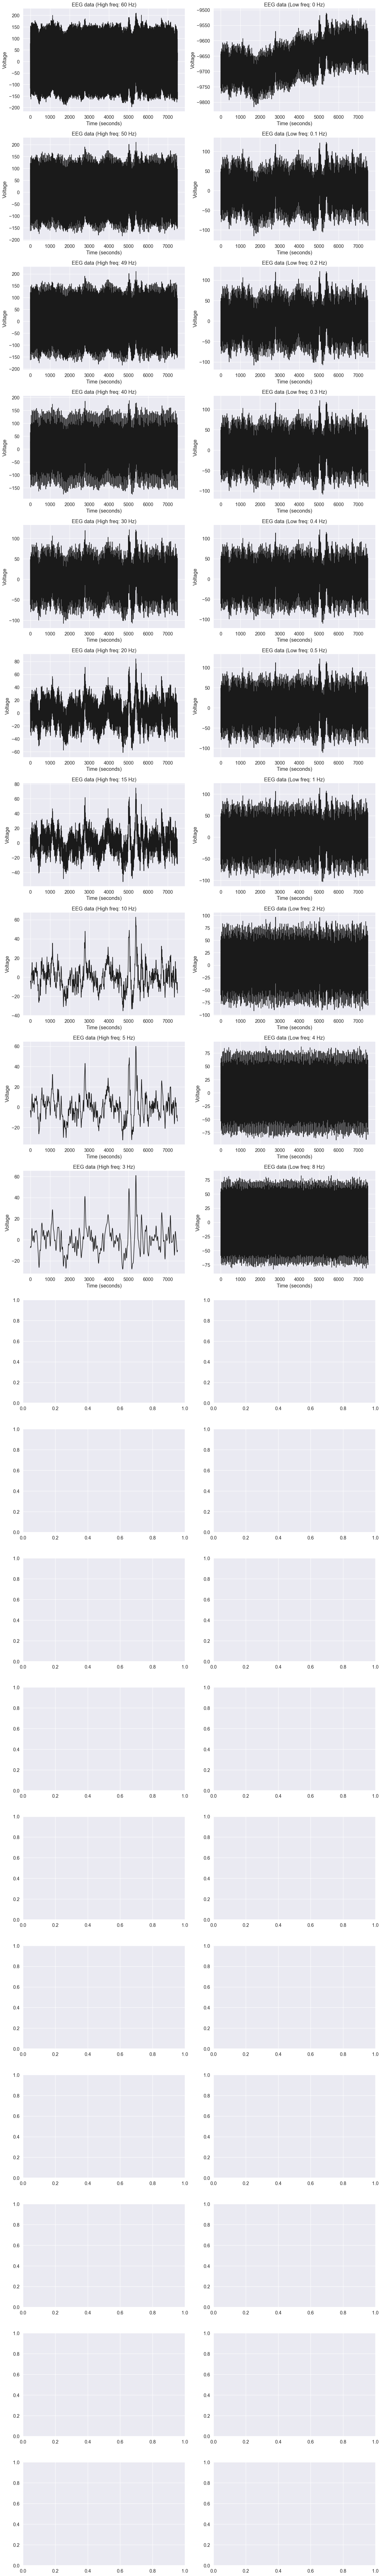

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import detrend
from mne.filter import filter_data

sns.set(font_scale=1.2)


# Define the frequency ranges
high_freqs = [60, 50, 49, 40, 30, 20, 15, 10, 5, 3]
low_freqs = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 1, 2, 4, 8]

# Create a figure with a 2-column layout
fig, axes = plt.subplots(len(high_freqs) + len(low_freqs), 2, figsize=(15, 5 * (len(high_freqs) + len(low_freqs))))

# Plot high frequency filtered signals
for i, high_freq in enumerate(high_freqs):
    dt_filt = filter_data(data_small_raw, sf, l_freq=0.2, h_freq=high_freq, verbose=False)
    epoch_filt = dt_filt[epoch_index_small * samples_per_epoch : (epoch_index_small + 1) * samples_per_epoch]
    ax = axes[i, 0]
    ax.plot(epoch_filt, lw=1.5, color='k')
    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('Voltage')
    ax.set_title(f'EEG data (High freq: {high_freq} Hz)')
    sns.despine()

# Plot low frequency filtered signals
for i, low_freq in enumerate(low_freqs):
    dt_filt = filter_data(data_small_raw, sf, l_freq=low_freq, h_freq=30, verbose=False)
    epoch_filt = dt_filt[epoch_index_small * samples_per_epoch : (epoch_index_small + 1) * samples_per_epoch]
    ax = axes[i, 1]
    ax.plot(epoch_filt, lw=1.5, color='k')
    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('Voltage')
    ax.set_title(f'EEG data (Low freq: {low_freq} Hz)')
    sns.despine()

plt.tight_layout()
plt.show()

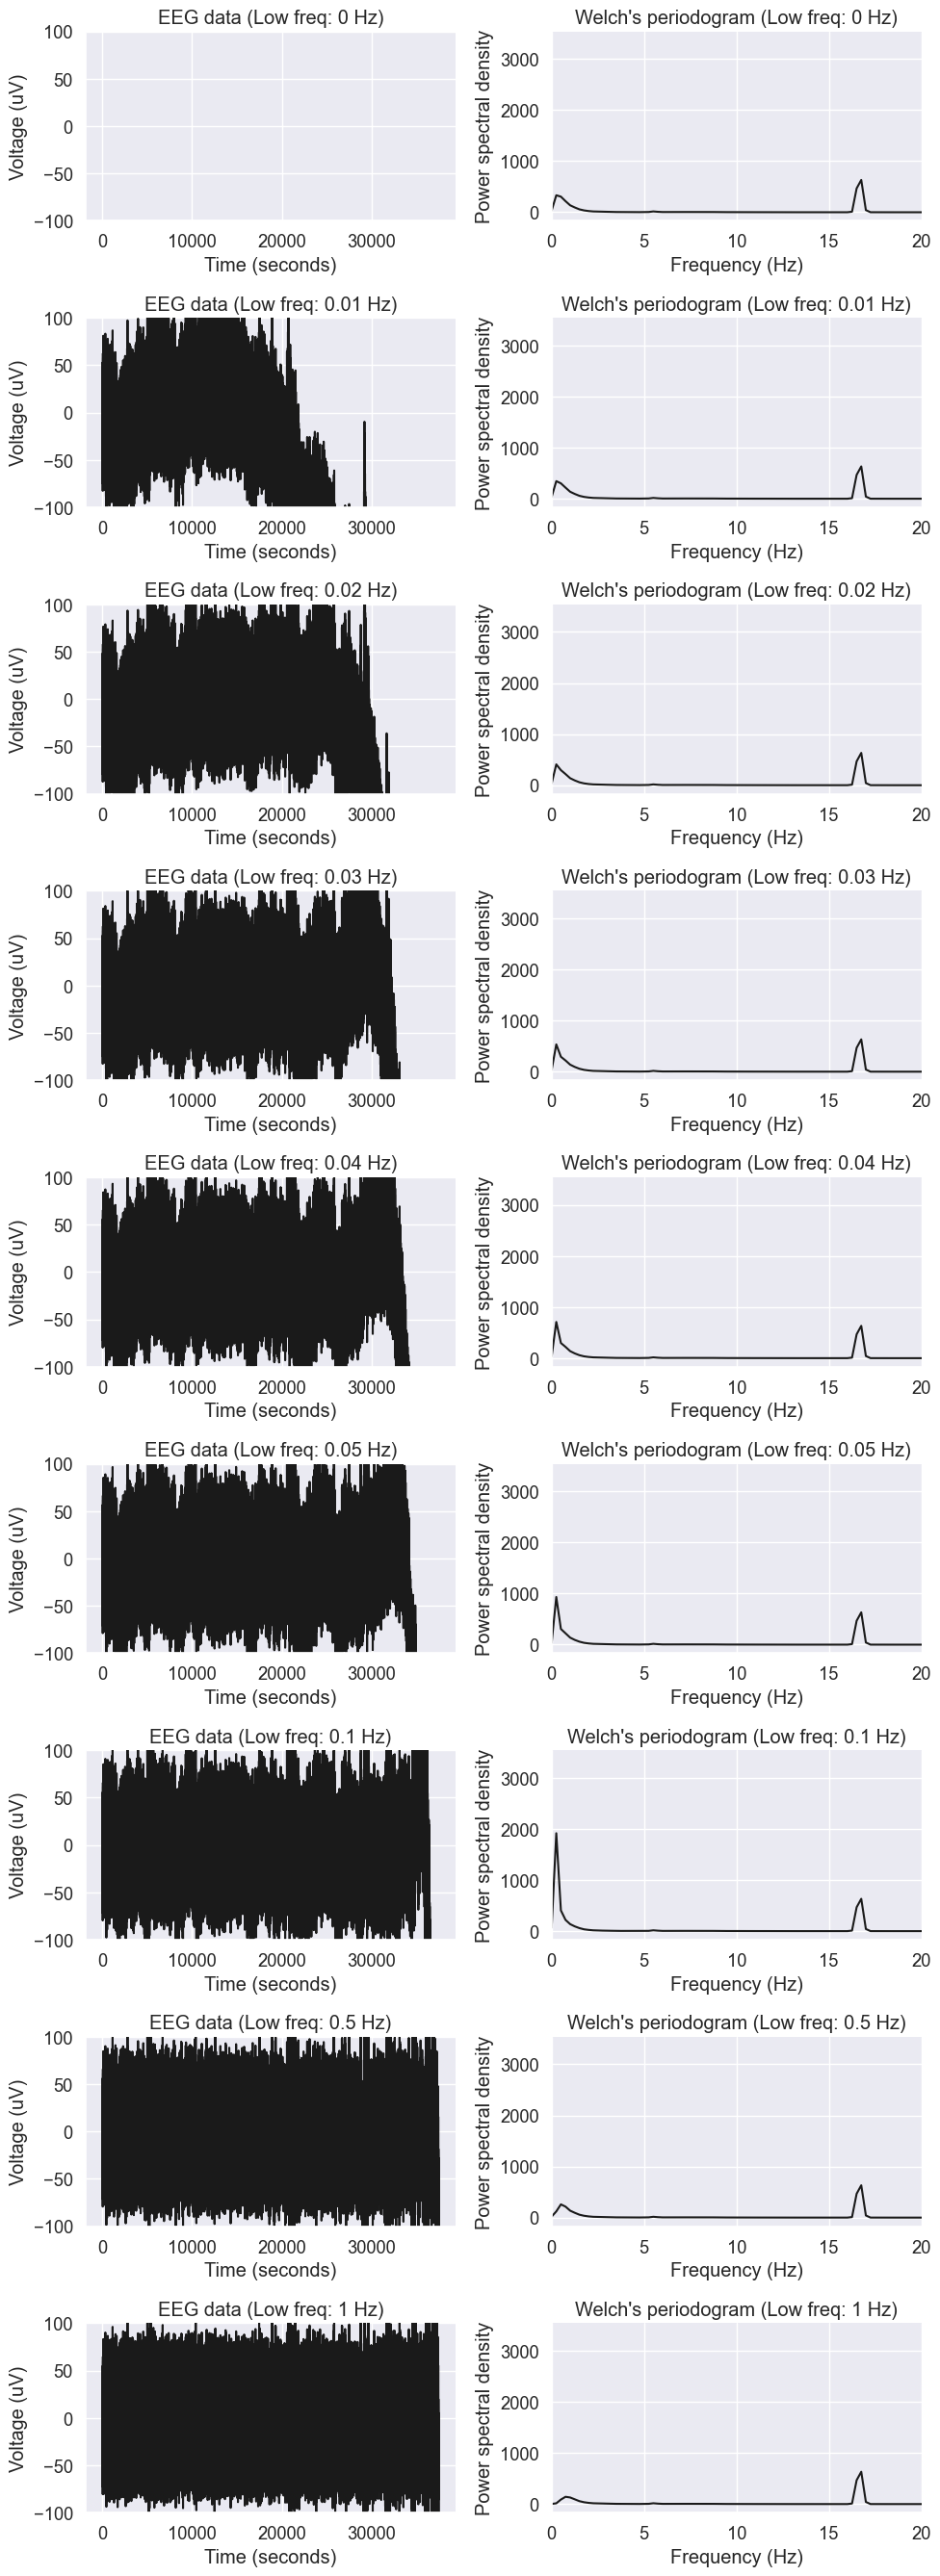

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import detrend, welch
from mne.filter import filter_data

sns.set(font_scale=1.2)

# Define the low frequency ranges up to 1 Hz, skipping 0.3 Hz
low_freqs = [0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.5, 1]

# Create a figure with a 2-column layout
fig, axes = plt.subplots(len(low_freqs), 2, figsize=(10, 3 * len(low_freqs)))

# Plot low frequency filtered signals and their Welch's periodograms
for i, low_freq in enumerate(low_freqs):
    # Filter the data
    dt_filt = filter_data(data_small_raw, sf, l_freq=low_freq, h_freq=30, verbose=False, method='fir')
    epoch_filt = dt_filt[epoch_index_small * samples_per_epoch : (epoch_index_small + 5) * samples_per_epoch]

    # Trim off start of data
    #epoch_filt = dt_filt[samples_per_epoch * 5:]


    # Plot the EEG signal
    ax = axes[i, 0]
    ax.plot(epoch_filt, lw=1.5, color='k')
    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('Voltage (uV)')
    ax.set_ylim([-100, 100])
    ax.set_title(f'EEG data (Low freq: {low_freq} Hz)')
    sns.despine()

    # Compute and plot Welch's periodogram
    freqs, psd = welch(epoch_filt, sf, nperseg=4*sf)
    ax = axes[i, 1]
    ax.plot(freqs, psd, lw=1.5, color='k')
    ax.set_xlabel('Frequency (Hz)')
    ax.set_xlim([0, 20])
    # ax.set_ylabel('Power spectral density (uV^2 / Hz)')
    ax.set_ylabel('Power spectral density')
    ax.set_title(f'Welch\'s periodogram (Low freq: {low_freq} Hz)')
    sns.despine()

plt.tight_layout()
plt.show()

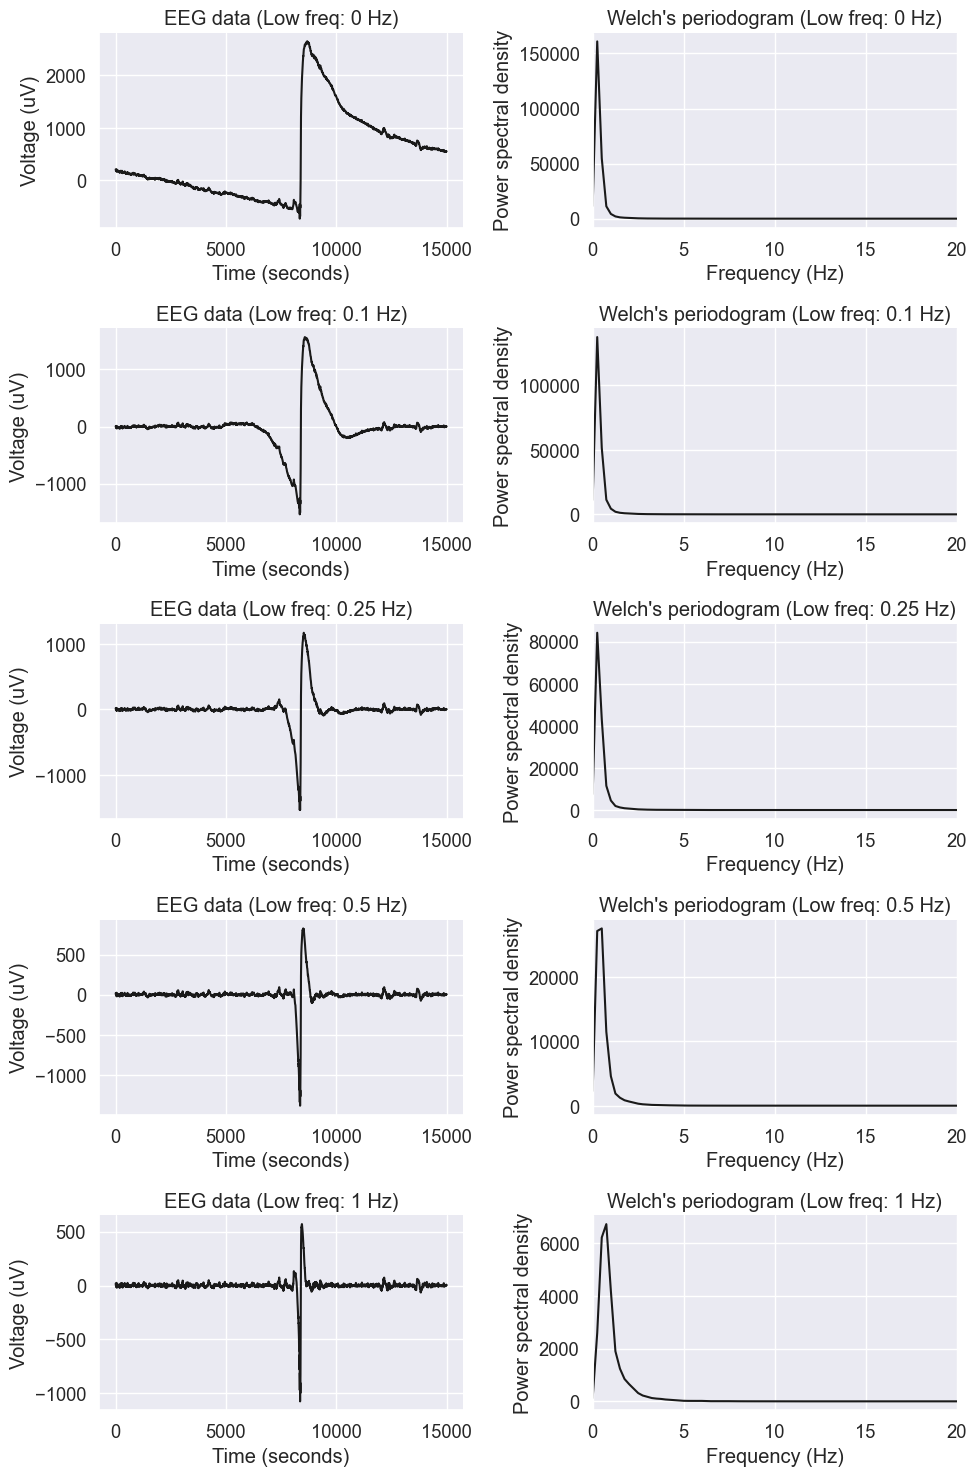

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import detrend, welch
from mne.filter import filter_data

sns.set(font_scale=1.2)

# Define the low frequency ranges up to 1 Hz, skipping 0.3 Hz
low_freqs = [0, 0.1, 0.25, 0.5, 1]

# Create a figure with a 2-column layout
fig, axes = plt.subplots(len(low_freqs), 2, figsize=(10, 3 * len(low_freqs)))

# Plot low frequency filtered signals and their Welch's periodograms
for i, low_freq in enumerate(low_freqs):
    # Filter the data
    dt_filt = filter_data(data_small_raw, sf, l_freq=low_freq, h_freq=30, verbose=False, method='fir')
    epoch_filt = dt_filt[835 * samples_per_epoch : (836 + 1) * samples_per_epoch]

    # Trim off start of data
    #epoch_filt = dt_filt[samples_per_epoch * 5:]


    # Plot the EEG signal
    ax = axes[i, 0]
    ax.plot(epoch_filt, lw=1.5, color='k')
    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('Voltage (uV)')
    #ax.set_ylim([-100, 100])
    ax.set_title(f'EEG data (Low freq: {low_freq} Hz)')
    sns.despine()

    # Compute and plot Welch's periodogram
    freqs, psd = welch(epoch_filt, sf, nperseg=4*sf)
    ax = axes[i, 1]
    ax.plot(freqs, psd, lw=1.5, color='k')
    ax.set_xlabel('Frequency (Hz)')
    ax.set_xlim([0, 20])
    # ax.set_ylabel('Power spectral density (uV^2 / Hz)')
    ax.set_ylabel('Power spectral density')
    ax.set_title(f'Welch\'s periodogram (Low freq: {low_freq} Hz)')
    sns.despine()

plt.tight_layout()
plt.show()

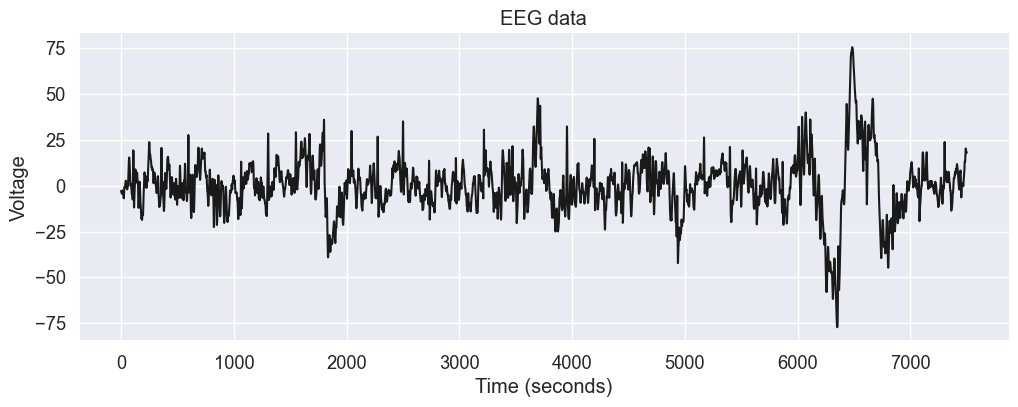

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.2)

from scipy.signal import detrend

# detrended_data = detrend(epoch_data, axis=0)
# freq_broad = (0.02, 30)

dt_filt = filter_data(data_small_raw, sf, l_freq=0.5, h_freq=30, verbose=False, method='fir')
epoch_filt = dt_filt[epoch_index_small * samples_per_epoch : (epoch_index_small + 1) * samples_per_epoch]

# dt_filt = filter_data(epoch_data, sf, l_freq=freq_broad[0], h_freq=freq_broad[1], verbose=False)

# Define sampling frequency and time vector

# Plot the signal
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
plt.plot(epoch_filt, lw=1.5, color='k')
plt.xlabel('Time (seconds)')
plt.ylabel('Voltage')
# plt.xlim([time_start, time_end])
plt.title('EEG data')
sns.despine()


In [54]:
from mne.filter import filter_data
freq_broad = (0.4, 30)
from yasa import SleepStaging, sliding_window, bandpower_from_psd_ndarray
import scipy.signal as sp_sig

# dt_filt = filter_data(epoch_data_small[0, :], sf, l_freq=freq_broad[0], h_freq=freq_broad[1], verbose=False)
# # - Extract epochs. Data is now of shape (n_epochs, n_samples).
# times, epochs = sliding_window(dt_filt, sf=sf, window=30)

bands = [
    (0.5, 1, "sdelta"),
    (1, 4, "fdelta"),
    (4, 8, "theta"),
    (8, 12, "alpha"),
    (12, 16, "sigma"),
    (16, 30, "beta"),
]

win_sec = 5  # = 2 / freq_broad[0]
win = int(win_sec * sf)

freq_broad = (0.5, 30)
# dt_filt = filter_data(epoch_data, sf, l_freq=freq_broad[0], h_freq=freq_broad[1], verbose=False)
# dt_filt = detrended_data

kwargs_welch = {
    "window": "hamming",
    "nperseg": win,
    "average": "median"
}

freqs, psd = sp_sig.welch([epoch_filt], sf, **kwargs_welch)
psd = psd[0]

df_psd = pd.DataFrame({'Frequency (Hz)': freqs, 'Power Spectral Density (uV^2 / Hz)': psd})

bp_abs = bandpower_from_psd_ndarray(psd, freqs, bands=bands, relative=False)
feat = {}
for j, (_, _, b) in enumerate(bands):
    feat[b + "abs"] = bp_abs[j]
df_psd

,Frequency (Hz),Power Spectral Density (uV^2 / Hz)
0,0.0,3.780807
1,0.2,67.934876
2,0.4,49.018892
3,0.6,81.006802
4,0.8,33.144491
...,...,...
621,124.2,0.000008
622,124.4,0.000008
623,124.6,0.000008
624,124.8,0.000008


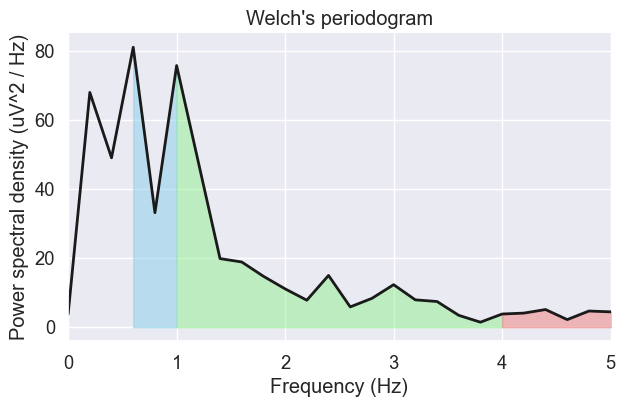

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


# Define window length (4 seconds)
win = 4 * sf
# freqs, psd = signal.welch(epoch_data_small, sf, nperseg=win)

# Define the bands

# Define colors for each band
colors = ['skyblue', 'lightgreen', 'lightcoral', 'lightpink', 'lightyellow', 'lightgray']

# Plot the power spectral density and fill the bands
plt.figure(figsize=(7, 4))
plt.plot(freqs, psd, lw=2, color='k')

for (low, high, label), color in zip(bands, colors):
    idx_band = np.logical_and(freqs >= low, freqs <= high)
    plt.fill_between(freqs, psd, where=idx_band, color=color, alpha=0.5, label=label)

plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (uV^2 / Hz)')
plt.xlim([0, 5])
# plt.ylim([0, 1])
plt.title("Welch's periodogram")
# plt.legend()
sns.despine()
plt.show()

In [55]:
df_psd

,Frequency (Hz),Power Spectral Density (uV^2 / Hz)
0,0.0,3.780807
1,0.2,67.934876
2,0.4,49.018892
3,0.6,81.006802
4,0.8,33.144491
...,...,...
621,124.2,0.000008
622,124.4,0.000008
623,124.6,0.000008
624,124.8,0.000008


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


# Define window length (4 seconds)
win = 4 * sf
# freqs, psd = signal.welch(epoch_data_small, sf, nperseg=win)

# Define the bands

# Define colors for each band
colors = ['skyblue', 'lightgreen', 'lightcoral', 'lightpink', 'lightyellow', 'lightgray']

# Plot the power spectral density and fill the bands
plt.figure(figsize=(7, 4))
plt.plot(freqs, psd, lw=2, color='k')

for (low, high, label), color in zip(bands, colors):
    idx_band = np.logical_and(freqs >= low, freqs <= high)
    plt.fill_between(freqs, psd, where=idx_band, color=color, alpha=0.5, label=label)

plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (uV^2 / Hz)')
plt.xlim([0, 5])
plt.ylim([0, 100])
plt.title("Welch's periodogram")
plt.legend()
sns.despine()
plt.show()

In [ ]:
import pandas as pd
from scipy.integrate import simpson

# Frequency resolution
freq_res = freqs[1] - freqs[0]

# Initialize a list to store the results
results = []

# Compute the absolute power for each band
for low, high, label in bands:
    idx_band = np.logical_and(freqs >= low, freqs <= high)
    band_power = simpson(psd[idx_band], dx=freq_res)
    results.append({'Band': label, 'Power (uV^2)': band_power})

# Convert the results to a DataFrame
df_band_powers = pd.DataFrame(results)

# Display the DataFrame
print(df_band_powers)

In [ ]:

def bandpower(data, sf, band, method='welch', window_sec=None, relative=False):
    """Compute the average power of the signal x in a specific frequency band.

    Requires MNE-Python >= 0.14.

    Parameters
    ----------
    data : 1d-array
      Input signal in the time-domain.
    sf : float
      Sampling frequency of the data.
    band : list
      Lower and upper frequencies of the band of interest.
    method : string
      Periodogram method: 'welch' or 'multitaper'
    window_sec : float
      Length of each window in seconds. Useful only if method == 'welch'.
      If None, window_sec = (1 / min(band)) * 2.
    relative : boolean
      If True, return the relative power (= divided by the total power of the signal).
      If False (default), return the absolute power.

    Return
    ------
    bp : float
      Absolute or relative band power.
    """
    from scipy.signal import welch
    from scipy.integrate import simpson
    from mne.time_frequency import psd_array_multitaper

    band = np.asarray(band)
    low, high = band

    # Compute the modified periodogram (Welch)
    if method == 'welch':
        if window_sec is not None:
            nperseg = window_sec * sf
        else:
            nperseg = (2 / low) * sf

        freqs, psd = welch(data, sf, nperseg=nperseg)

    elif method == 'multitaper':
        psd, freqs = psd_array_multitaper(data, sf, adaptive=True,
                                          normalization='full', verbose=0)

    # Frequency resolution
    freq_res = freqs[1] - freqs[0]

    # Find index of band in frequency vector
    idx_band = np.logical_and(freqs >= low, freqs <= high)

    # Integral approximation of the spectrum using parabola (Simpson's rule)
    bp = simpson(psd[idx_band], dx=freq_res)

    if relative:
        bp /= simps(psd, dx=freq_res)
    return bp

bandpower(epoch_data, sf, [0.4, 1], method='multitaper', window_sec=4)


In [ ]:
!pip install --upgrade scipy

In [ ]:
from scipy import simpson